## Carregamento e preparo dos dados

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import optuna
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('yeast.data',
                       sep = '\s+',
                       header=None,
                       names=["Sequence Name","mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "label"]
                      )
raw_data.head()

,Sequence Name,mcg,gvh,alm,mit,erl,pox,vac,nuc,label
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


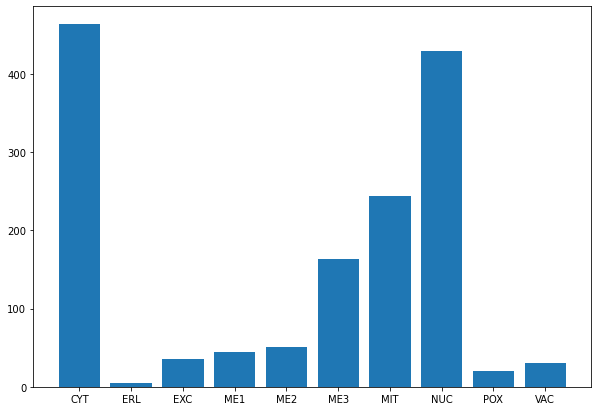

In [3]:
labels, count = np.unique(raw_data["label"], return_counts=True)
plt.figure(figsize=(10,7))
plt.bar(labels, count);

#### Descartando os atributos categóricos:

In [4]:
labelEnc = LabelEncoder()
label = raw_data["label"]
y = labelEnc.fit_transform(raw_data["label"])

In [5]:
df = raw_data.drop(columns=["Sequence Name", "label"])
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


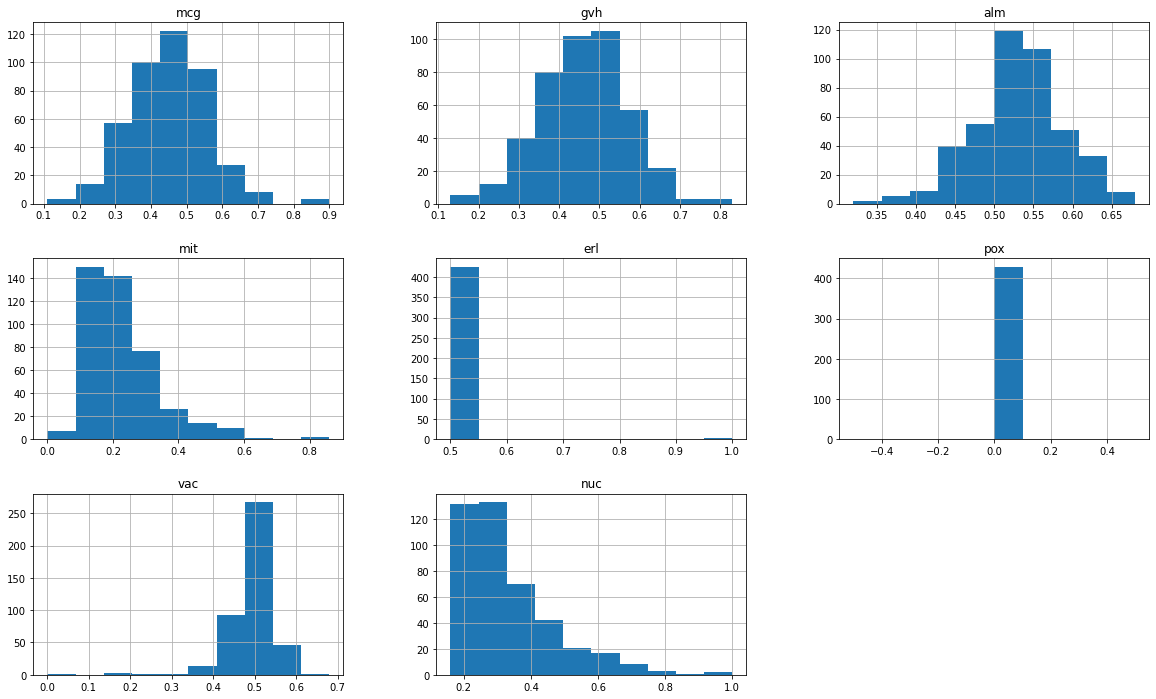

In [6]:
raw_data[raw_data["label"]== "NUC"].hist(figsize=(20,12));

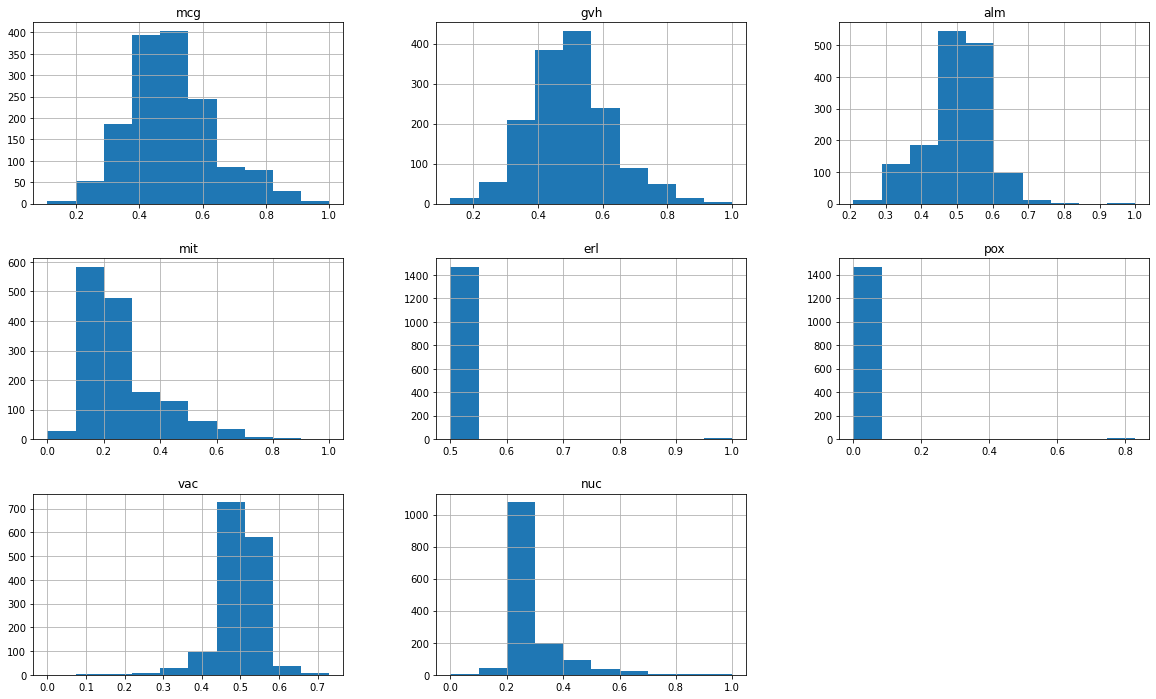

In [7]:
df.hist(figsize=(20,12));

In [8]:
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


Sem dados faltantes

In [9]:
df.isna().sum()

mcg    0
gvh    0
alm    0
mit    0
erl    0
pox    0
vac    0
nuc    0
dtype: int64

## FCM-DFCV
#### A fuzzy clustering method based on an adaptive quadratic distance for each cluster defined by a diagonal fuzzy covariance matrix

#### Conceito:

É utilizado uma função softmax na inicialização aleatória de U, pois é ideal que a matriz U tenha  $\sum_{i=1}^{c} u_{ik} = 1$, ou seja, a soma dos graus de pertinência de uma amostra para todas as classe tem que ser 1.

In [10]:
3 * np.random.rand(2, 2)

array([[0.93435958, 1.97255633],
       [2.82651161, 1.16894943]])

In [11]:
softmax(3 * np.random.rand(2, 2), axis=0)

array([[0.1827456 , 0.66232878],
       [0.8172544 , 0.33767122]])

#### Classe do modelo:


In [12]:
class FCM_DFCV:
    def __init__(self, n_class, m, T, epsilon, rand_value_init_U, mim_distance=0.00001):
        self.n_class = n_class
        self.m = m
        self.T = T
        self.epsilon = epsilon
        self.mim_distance = mim_distance
        self.rand_value_init_U = rand_value_init_U
        self.loss = []
        
    def fit(self, df):
        
        self.n = df.shape[0]
        self.p = df.shape[1]

        for i in range(self.T):

            if i == 0:

               #Inicializacao da matriz de perminência aleatória
                U = self.init_U_random()
                #G_anterior interacao 0
                G = np.zeros([self.n_class, self.p])
                M = np.zeros([self.n_class, self.p, self.p])
                J = np.inf
                self.J_best = J

            else:
                #Calculo da matriz de pertinência
                U = self.calc_U(D_M)
                #break
            
            #Calculo dos prototipos    
            G = self.calc_G(df, U, G)
            #import pdb;pdb.set_trace()    

            M = self.calc_M(U, df, G, M)
            #Calculo das distâncias quadraticas
            D_M = self.calc_D_M(df, G, M)
            
            #Calculo da função de custo
            J_ant = J
            J = self.calc_J(U, D_M)
            #self.plot(G)
            
            self.loss.append(J)
            if self.J_best > J :
                self.J_best = J
                self.U = U
                self.G = G
                
            if np.abs(J - J_ant) < self.epsilon:
                break
                
    
    def plot(self, G):
        colors = cm.rainbow(np.linspace(0, 1, len(range(self.n_class))))
        fig, axs = plt.subplots(2, 2, figsize=(12,12))
        axs[0, 0].scatter(G[:,0], G[:,1], c=colors)
        axs[0, 0].set_title('Feature 0-1')
        axs[0, 1].scatter(G[:,2], G[:,3], c=colors)
        axs[0, 1].set_title('Feature 2-3')
        axs[1, 0].scatter(G[:,4], G[:,5], c=colors)
        axs[1, 0].set_title('Feature 4-5')
        axs[1, 1].scatter(G[:,6], G[:,7], c=colors)
        axs[1, 1].set_title('Feature 6-7')
        plt.show()
        
    #Inicialização aleatoria da matrix de pertinencia U    
    def init_U_random(self):
        return softmax(self.rand_value_init_U * np.random.rand(self.n_class, self.n), axis=0)
    
    def calc_U(self, D_M):
        U = np.zeros([self.n_class, self.n])
        for k in range(self.n):
            
            argmin_values = np.argwhere( D_M[:, k] < self.mim_distance)
            
            if len(argmin_values) > 0 :
                i = argmin_values[0][0]
                U[:, k] = 0
                U[i, k] = 1
            else:
                
                for i in range(self.n_class):
                        U[i, k] = np.around(( ( (D_M[i, k] / D_M[:,k])** (1 / (self.m - 1) ) ).sum()) ** (-1), decimals=6)

        return U
    
    def calc_G(self, df, U, G_ant):
        G = np.zeros([self.n_class, self.p])
        U_m = U ** self.m

        for i in range(self.n_class):
            
            U_i = U_m[i, :].reshape([self.n, 1])
            #Formula (3)
            U_i_sum = U_i.sum()

            if U_i_sum > 0.000001:
                G[i, :] = (U_i * df).sum(axis=0) / U_i_sum
            else:
                G[i, :] = G_ant[i, :]
 
        
        return G
    
    def calc_J(self, U, D_M):
        U_m = U ** self.m
        J = (U_m * D_M).sum()
        return J
    
    def calc_M(self, U, df, G, M_ant):
        U_m = U ** self.m
        M = np.zeros([self.n_class, self.p, self.p])
        
        for i in range(self.n_class):

            U_i = U_m[i, :].reshape([self.n, 1])
            sum_features = (U_i*(df - G[i])**2).sum()
            lambda_i = np.prod((U_i * (df - G[i])**2).sum(axis=0)**(1/self.p)) / sum_features 
            M_i = np.diag(lambda_i)
            
            if np.isnan(M_i).sum() > 0:           
                M_i = M_ant[i]

                
                
            M[i, :, :] = M_i
               

        return M
    
    def calc_D_M(self, df, G, M):
        D_M = np.zeros([self.n_class, self.n])
        df_ = df.to_numpy()
        for k in range(self.n):
            for i in range(self.n_class):
                x_k = df_[k].reshape([1,self.p])
                g_i = G[i]
                M_i = M[i]
                
                # A matriz transposta foi utilizada no ultimo termo
                # pois o x_k já está no formato (1,p) 
                # e será feito o produto matricial com M que é no formato (p, p)
                parcial = np.dot((x_k - g_i), M_i)
                D_M[i, k] =  np.dot(parcial, (x_k - g_i).T)

        return D_M

### Métricas

#### Modified Partition Coeficient

In [13]:
def Partition_Coefficient(U, N):
    return (U ** 2).sum()/ N

def Modified_Partition_Coefficient(U, K, N):
    PC = Partition_Coefficient(U, N)
    return 1 - K/(K - 1)*(1 - PC)

#### Partition Coefficient

In [14]:
def Partition_Entropy(U, N):
    return -1/N * (U * np.log2(U + 0.000001)).sum()

#### Adjusted Rand Score

Utilizando adjusted_rand_score do Sklearn

#### F-Measure

In [15]:
def F_measure(cf_m):
    n_i = cf_m.sum(axis=0)
    n_j = cf_m.sum(axis=1)
    F = 0
    for j in range(K):
        n_ij = cf_m[j, :]
        max_value = np.nanmax( ( n_ij / n_i *  n_ij / n_j[j])/ (  n_ij / n_i +  n_ij / n_j[j] ))
        F += n_j[j] / N * max_value
    return F

### Busca pelos melhores parâmetros

#### Hiperparâmetros

In [16]:
N = df.shape[0]
K = 10

In [17]:
parameters = {
    "m": [1.1, 1.6, 2.0],
    "c": [10],
    "T": [150],
    "epsilon": [10e-10],
    "rand_value_init_U": [1, 4, 7, 8, 9, 10, 11, 15, 50, 60, 65, 75, 24, 44, 80, 90] #15

}

In [18]:
def objective(trial):
    
    ##  Parametros ####
    m = trial.suggest_float("m", 1.1, 10)
    epsilon = trial.suggest_float("epsilon", 0, 1)
    T = trial.suggest_int("T", 100, 150)
    c = trial.suggest_int("c", 10, 10)
    rand_value_init_U = trial.suggest_int("rand_value_init_U", 1, 100)

    #  Modelo ####
    model = FCM_DFCV(n_class=c, m=m, T=T, epsilon=epsilon, rand_value_init_U=rand_value_init_U)
    model.fit(df)
    J = model.J_best
    trial.set_user_attr(key="J", value = J)

    trial.set_user_attr(key="model", value=model)
    U = model.U
    
    # Métricas ###############

    # Modified_Partition_Coefficient
    mod_part_coef = Modified_Partition_Coefficient(U, K, N)
    trial.set_user_attr(key="mod_part_coef", value = mod_part_coef)
    
    # Partition_Entropy
    part_entropy = Partition_Entropy(U, N)
    trial.set_user_attr(key="part_entropy", value = part_entropy)

    
    ### Criação da representação CRISP
    U_predict_crisp = np.argmax(U, axis=0)
    
    # adjusted_rand_score
    # y é a prediçao correta dos dados 
    adjusted_rand = adjusted_rand_score(y, U_predict_crisp)
    trial.set_user_attr(key="adjusted_rand", value = adjusted_rand)
    
    #Calculo da f_measure
    confu_matrix = confusion_matrix(y, U_predict_crisp)
    f_measure = F_measure(confu_matrix)
    trial.set_user_attr(key="f-measure", value = f_measure)

    return J




def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(
            key="best_model", value=trial.user_attrs["model"]
        )
    
study = optuna.create_study(sampler=optuna.samplers.GridSampler(parameters))
study.optimize(objective, callbacks=[callback])

[I 2021-07-27 14:08:18,962] A new study created in memory with name: no-name-81ec973f-7df8-42ab-8ae9-68c79a5ddc0e
[I 2021-07-27 14:09:10,091] Trial 0 finished with value: 8.669129054381033 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 9}. Best is trial 0 with value: 8.669129054381033.
[I 2021-07-27 14:09:37,316] Trial 1 finished with value: 6.198960284278971 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 15}. Best is trial 1 with value: 6.198960284278971.
[I 2021-07-27 14:10:20,583] Trial 2 finished with value: 1.841099410030894 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 65}. Best is trial 2 with value: 1.841099410030894.
[I 2021-07-27 14:10:34,813] Trial 3 finished with value: 16.39513269171741 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 90}. Best is trial 2 with value: 1.841099410030894.
[I 2021-07-27 14:11:49,059] Trial 4 fin

[I 2021-07-27 14:38:05,105] Trial 36 finished with value: 0.6191152013439214 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 65}. Best is trial 15 with value: 0.24800406152856783.
[I 2021-07-27 14:38:32,841] Trial 37 finished with value: 0.7053963221254271 and parameters: {'m': 1.6, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 10}. Best is trial 15 with value: 0.24800406152856783.
[I 2021-07-27 14:39:06,577] Trial 38 finished with value: 0.22760974561625996 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 8}. Best is trial 38 with value: 0.22760974561625996.
[I 2021-07-27 14:40:07,722] Trial 39 finished with value: 0.7950962358005924 and parameters: {'m': 2.0, 'epsilon': 1e-09, 'T': 150, 'c': 10, 'rand_value_init_U': 24}. Best is trial 38 with value: 0.22760974561625996.
[I 2021-07-27 14:41:10,112] Trial 40 finished with value: 22.188413471940645 and parameters: {'m': 1.1, 'epsilon': 1e-09, 'T': 150, 

In [60]:
fmeasures = []
for trial in study.trials:
    fmeasures.append(trial.user_attrs['f-measure'])
    #print(f"F-measure = {}")
print("best fmeasure", np.argmax(fmeasures))

best fmeasure 8


In [19]:
for trial in study.trials:
    print(f"trial {trial.number}, params={{'m':{trial.params['m']},'rand_init_U':{trial.params['rand_value_init_U']}}}")
    print(f"Modified Partition Coefficient = {trial.user_attrs['mod_part_coef']}")
    print(f"Partition Entropy = {trial.user_attrs['part_entropy']}")
    print(f"Adjusted Rand = {trial.user_attrs['adjusted_rand']}")
    print(f"F-measure = {trial.user_attrs['f-measure']}")
    print(f"J = {trial.user_attrs['J']}")
    print('\n------\n')

trial 0, params={'m':1.1,'rand_init_U':9}
Modified Partition Coefficient = 0.9232232699157205
Partition Entropy = 0.1772102025379007
Adjusted Rand = 0.051338903297959905
F-measure = 0.2005198093492421
J = 8.669129054381033

------

trial 1, params={'m':1.1,'rand_init_U':15}
Modified Partition Coefficient = 0.9271930114668345
Partition Entropy = 0.15871606355404344
Adjusted Rand = 0.07043909168490119
F-measure = 0.20247142091215706
J = 6.198960284278971

------

trial 2, params={'m':1.6,'rand_init_U':65}
Modified Partition Coefficient = 0.7564694980522483
Partition Entropy = 0.7116756691500091
Adjusted Rand = 0.06731757385331318
F-measure = 0.20504634295659757
J = 1.841099410030894

------

trial 3, params={'m':1.1,'rand_init_U':90}
Modified Partition Coefficient = 0.9817268519637083
Partition Entropy = 0.0398182259307803
Adjusted Rand = 0.07101254218728285
F-measure = 0.21793400207470373
J = 16.39513269171741

------

trial 4, params={'m':2.0,'rand_init_U':50}
Modified Partition Coeffi

## Melhor modelo

In [61]:
best_i_trial = 8
best_trial = study.trials[best_i_trial]
#best_trial = study.best_trial

In [62]:
best_model = best_trial.user_attrs["model"]

In [63]:
U = best_model.U
G = best_model.G

#### i) Posições dos protótipos

In [64]:
for i in range(K):
    print(f"Protótipo {i}: ", end='')
    for p in range(8):
        print(f"{round(G[i,p], 7)}, ", end='')
    print("")

Protótipo 0: 0.5050249, 0.5215635, 0.5136201, 0.5258236, 0.5, 0.0, 0.505248, 0.2542122, 
Protótipo 1: 0.3700016, 0.5299985, 0.5999995, 0.1899998, 0.5, 0.5, 0.4200008, 0.22, 
Protótipo 2: 0.4609293, 0.4535492, 0.5424714, 0.2155304, 0.5, 0.0, 0.4898822, 0.2394836, 
Protótipo 3: 0.4733315, 0.4666826, 0.4900583, 0.3135215, 1.0, 0.0, 0.4733509, 0.22, 
Protótipo 4: 0.4483496, 0.4491835, 0.5186008, 0.2250051, 0.5, 0.0, 0.5053104, 0.5055996, 
Protótipo 5: 0.6990782, 0.6694701, 0.439974, 0.2729967, 0.5, 0.0, 0.510524, 0.2477529, 
Protótipo 6: 0.5114287, 0.4942861, 0.5049998, 0.2578576, 0.5, 0.7592859, 0.5150001, 0.2385717, 
Protótipo 7: 0.4849361, 0.4703852, 0.5025442, 0.1543614, 1.0, 0.0, 0.5350274, 0.3362223, 
Protótipo 8: 0.405984, 0.4682754, 0.3612981, 0.2037195, 0.5, 0.0, 0.5141884, 0.2634174, 
Protótipo 9: 0.7915225, 0.7737283, 0.4832437, 0.3356405, 1.0, 0.0, 0.5459678, 0.2459695, 


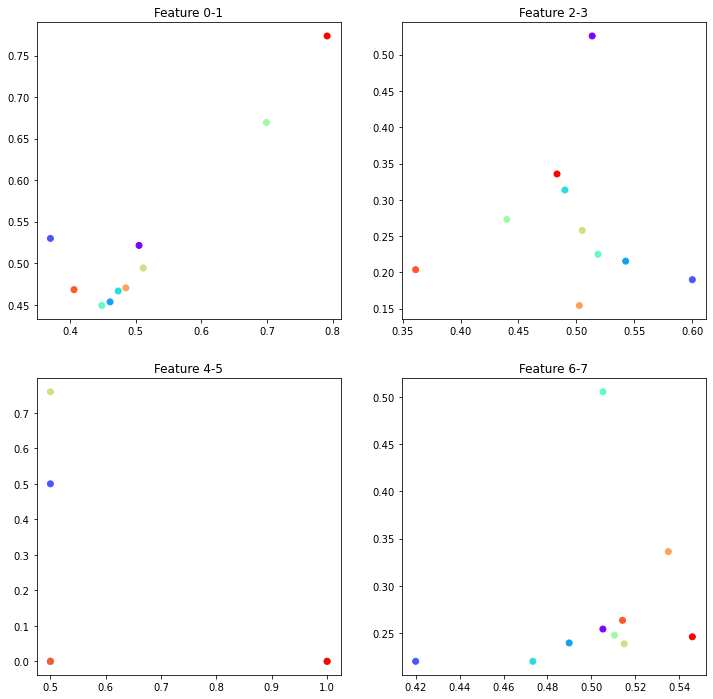

In [65]:
best_model.plot(G)

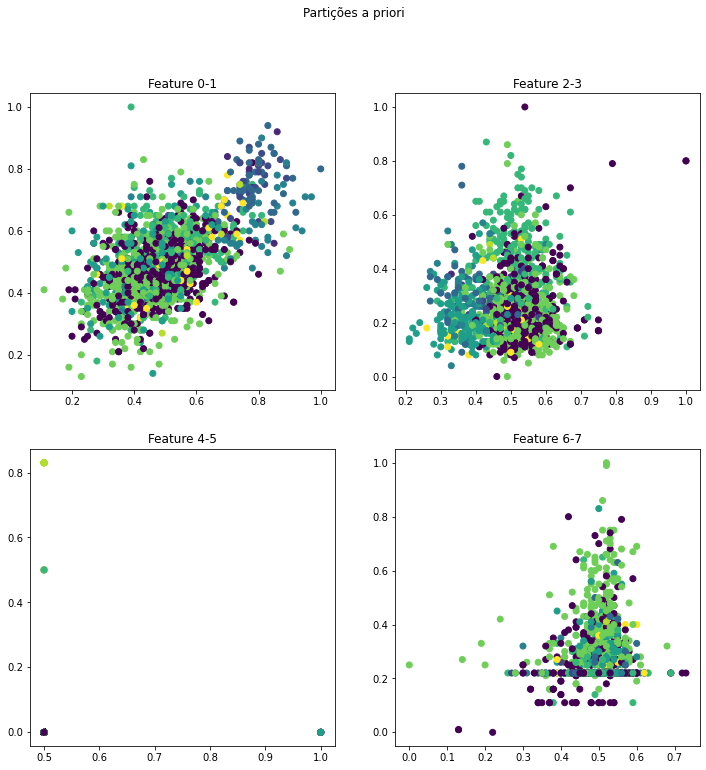

In [66]:
U_crisp = np.argmax(U, axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Partições a priori')
axs[0, 0].scatter(df.iloc[:,0], df.iloc[:,1], c=y)
axs[0, 0].set_title('Feature 0-1')
axs[0, 1].scatter(df.iloc[:,2], df.iloc[:,3], c=y)
axs[0, 1].set_title('Feature 2-3')
axs[1, 0].scatter(df.iloc[:,4], df.iloc[:,5], c=y)
axs[1, 0].set_title('Feature 4-5')
axs[1, 1].scatter(df.iloc[:,6], df.iloc[:,7], c=y)
axs[1, 1].set_title('Feature 6-7')
plt.show();

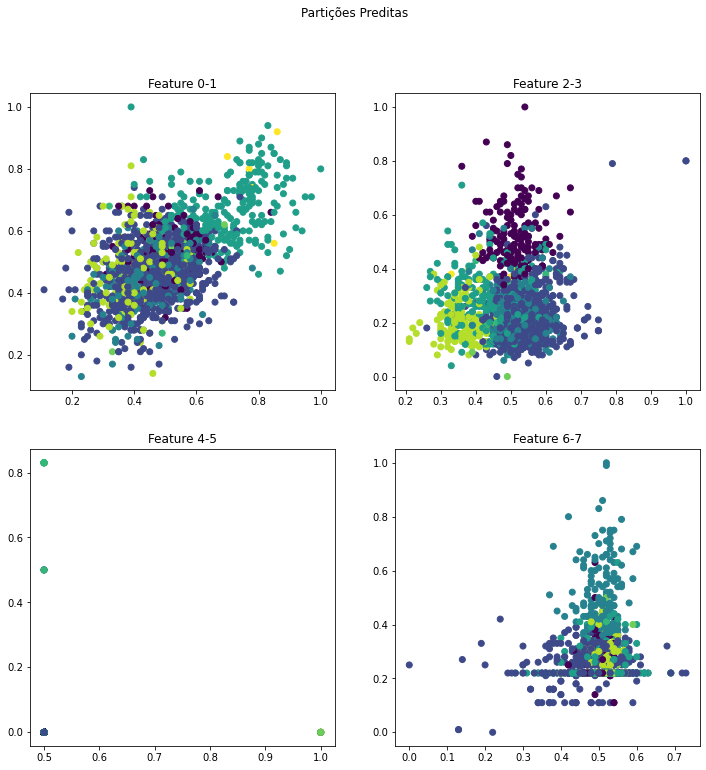

In [67]:
U_crisp = np.argmax(U, axis=0)
fig, axs = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Partições Preditas')
axs[0, 0].scatter(df.iloc[:,0], df.iloc[:,1], c=U_crisp)
axs[0, 0].set_title('Feature 0-1')
axs[0, 1].scatter(df.iloc[:,2], df.iloc[:,3], c=U_crisp)
axs[0, 1].set_title('Feature 2-3')
axs[1, 0].scatter(df.iloc[:,4], df.iloc[:,5], c=U_crisp)
axs[1, 0].set_title('Feature 4-5')
axs[1, 1].scatter(df.iloc[:,6], df.iloc[:,7], c=U_crisp)
axs[1, 1].set_title('Feature 6-7')
plt.show();

In [68]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df, y=y)

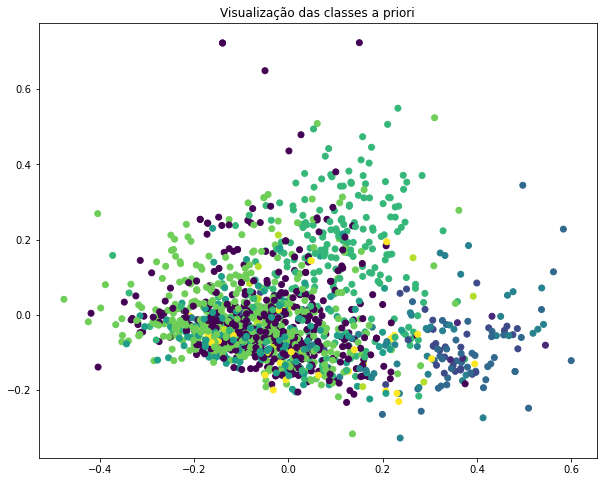

In [72]:
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1], c=y,)
plt.title("Visualização das classes a priori");

In [73]:
np.unique(U_crisp, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([169,   1, 722,   3, 173, 239,  14,   6, 152,   5]))

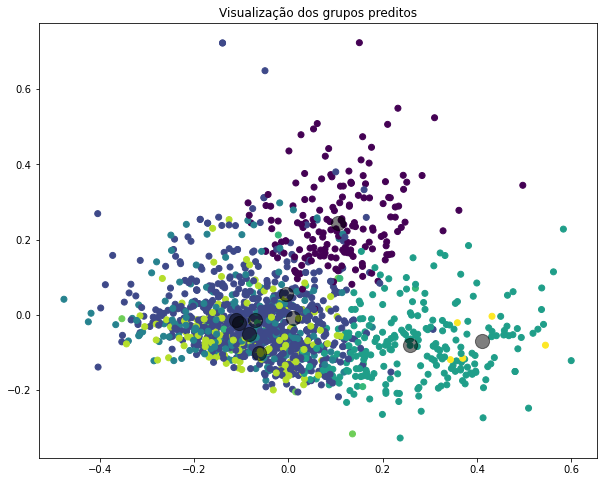

In [74]:
U_crisp = np.argmax(U, axis=0)
plt.figure(figsize=(10,8))
plt.scatter(df_pca[:,0], df_pca[:,1], c=U_crisp)
plt.scatter(pca.transform(G)[:,0], pca.transform(G)[:, 1], c='black', s=200, alpha=0.5);

plt.title("Visualização dos grupos preditos");

#### ii) Matriz Confusão

In [75]:
cf_matrix = pd.DataFrame(
    confusion_matrix(y, U_crisp),
    index=labelEnc.inverse_transform(list(range(10))),
    columns=[f"Part_{i}" for i in range(10)]
)

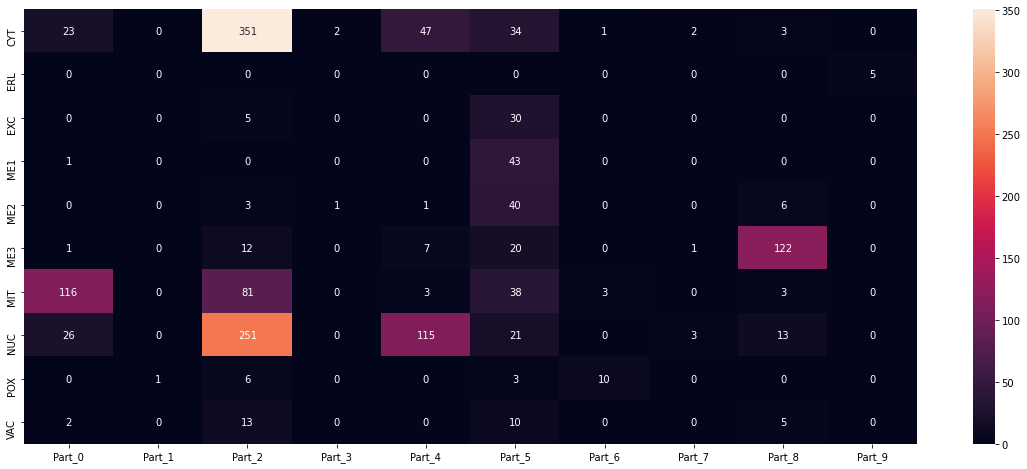

In [76]:
import seaborn as sns
plt.figure(figsize=(20,8))
sns.heatmap(cf_matrix, annot=True, fmt='');

#### iii) Modified partition coefficient

In [ ]:
print("Modified partition coefficient:", best_trial.user_attrs["mod_part_coef"])

#### iv)  Partition entropy

In [ ]:
print("Partition entropy:", best_trial.user_attrs["part_entropy"])

#### v) Indice de Rand corrigido, a F-measure e erro de classificação

In [ ]:
print("Indice de Rand corrigido:", best_trial.user_attrs["adjusted_rand"])

In [ ]:
print("F-measure:", best_trial.user_attrs["f-measure"])

In [ ]:
print("Erro de Classificação:", best_trial.user_attrs["J"])